In [1]:
import numpy as np
import sys
import time
import os
import h5py
import os.path as op
import matplotlib.cm as cm
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
import array
%matplotlib inline
sys.path.append('..')
from zwatershed import *
from visualization.visualize_funcs import *
from edgelist_methods import *
path_to_folder = '/Users/chandansingh/drive/janelia/conv_net_scripts/'
path_to_data = path_to_folder + 'data/'
from multiprocessing import Pool

# -------------------------------- parameters ---------------------------------------
pred_file = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/sample_A_x1_y1_z1_xy1.h5'
pred_file_2 = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/cutout_3k.h5'
out_folder = '/nobackup/turaga/singhc/par_zwshed/'
threshes = [2000]
cmap = matplotlib.colors.ListedColormap(np.vstack(((0, 0, 0), np.random.rand(255, 3))))
NUM_WORKERS = 2

In [2]:
f = h5py.File(pred_file, 'r') # only key is main
preds = f['main']
print preds.shape

(3, 125, 1250, 1250)


# Divide Volumes, set up args

In [5]:
def zwshed_h5_par(arg):
    (pred_vol,threshes,seg_save_path) = arg
    print "calculating",seg_save_path,"watershed"
    zwatershed_h5(pred_vol, threshes,seg_save_path)
    print "finished",seg_save_path,"watershed"
def dim_to_name(start):
    return str(start[0])+'_'+str(start[1])+'_'+str(start[2])+'/'

In [57]:
MAX_LEN = 400
dims = np.array((preds.shape[1:]))
print "dims",dims # x,y,z
num_vols = np.array([int(x/MAX_LEN)+1 for x in dims])
deltas = dims/num_vols
print "num_vols",num_vols
print "deltas",deltas
starts = []
ends = []
for x in range(num_vols[0]):
    for y in range(num_vols[1]):
        for z in range(num_vols[2]):
            starts.append((x,y,z)*deltas)
            extra = 3*np.array([x==num_vols[0]-1,y==num_vols[1]-1,z==num_vols[2]-1],dtype='int')
            ends.append((x,y,z)*deltas + deltas + [1,1,1]+extra)
args = []
for i in range(4): # len(starts)):
    s = starts[i]
    e = ends[i]
    pred_vol = preds[:,s[0]:e[0],s[1]:e[1],s[2]:e[2]]
    print s,e,pred_vol.shape
    args.append((pred_vol,threshes,out_folder+dim_to_name(s)))    

dims [ 125 1250 1250]
num_vols [1 4 4]
deltas [125 312 312]
[0 0 0] [129 313 313] (3, 125, 313, 313)
[  0   0 312] [129 313 625] (3, 125, 313, 313)
[  0   0 624] [129 313 937] (3, 125, 313, 313)
[  0   0 936] [ 129  313 1252] (3, 125, 313, 314)


# Call Watershed

In [58]:
p = Pool(NUM_WORKERS)
p.map(zwshed_h5_par, args)

calculating /nobackup/turaga/singhc/par_zwshed/0_0_0/ watershed
calculating /nobackup/turaga/singhc/par_zwshed/0_0_312/ watershed
finished /nobackup/turaga/singhc/par_zwshed/0_0_0/ watershed
calculating /nobackup/turaga/singhc/par_zwshed/0_0_624/ watershed


IOError: Unable to create file (Unable to truncate a file which is already open)

# Stitch

calculating zbars...
zbar shape (125, 313, 1250)
	[0 0 0] [129 313 313] (125, 313, 313) 1409
	[  0   0 312] [129 313 625] (125, 313, 313) 2954
	[  0   0 624] [129 313 937] (125, 313, 313) 4860
	[  0   0 936] [ 129  313 1252] (125, 313, 314) 6598
calculating ybars...
done


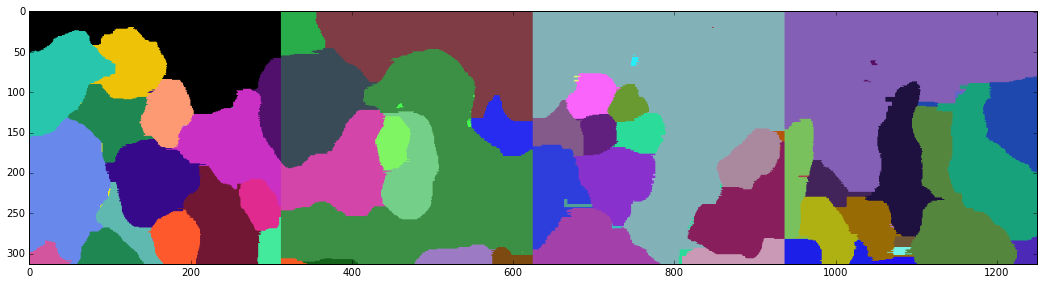

In [63]:
# todo - have this support several threshes
print "calculating zbars..."
i = 0
zbars = {}
for x in range(1): #num_vols[0]):
    for y in range(1): #num_vols[1]):
        xdim,ydim = deltas[0]+1,deltas[1]+1
        if x==num_vols[0]-1:
            xdim = dims[0]-deltas[0]*(num_vols[0]-1)
        if y==num_vols[1]-1:
            xdim = dims[1]-deltas[1]*(num_vols[1]-1)
        zbar = np.zeros((xdim,ydim,dims[2]),dtype='uint64')
        print "zbar shape",zbar.shape
        renums = {}
        for z in range(4): #num_vols[2]):
            # merge along z axis - fills in zbar
            inc_max = np.max(zbar)
            arg = args[i]
            s = starts[i]
            e = ends[i]
            # for filename in os.listdir(arg[2]):
            filename = 'seg_2000.h5'
            seg_h5 = h5py.File(arg[2]+filename,'r')
            seg = seg_h5['main']
            if z==0: # don't merge
                zbar[:,:,s[2]:e[2]] = seg[:,:,:] + inc_max
            else: # merge
                edge_old = zbar[:,:,s[2]].flatten()
                edge_new = seg[:,:,0].flatten()
#                edge_mins = np.minimum(edge_old,edge_new_)
#                 edge_maxes = 
                # for i in range(len)
#                 while edge_new in renums:
#                     edge_new = renums[edge_new]
                zbar[:,:,s[2]:e[2]] = seg[:,:,:] + inc_max
            print "\t",s,e,seg.shape, np.max(zbar)
            i+=1
        zbars[(x,y)] = zbar
        
        
print "calculating ybars..."
seg_out = np.zeros(dims,dtype='uint64') # x,y,z
print "done"
for key in zbars:
    bar = zbars[key]
    display_seg_z(bar)

# Visualize

In [136]:
for arg in args:
    for filename in os.listdir(arg[2]):
        seg_h5 = h5py.File(arg[2]+filename,'r')
        seg = seg_h5['main']
        print arg[2],seg.shape

/nobackup/turaga/singhc/par_zwshed/0_0_0/ (125, 313, 313)
/nobackup/turaga/singhc/par_zwshed/0_0_312/ (125, 313, 313)


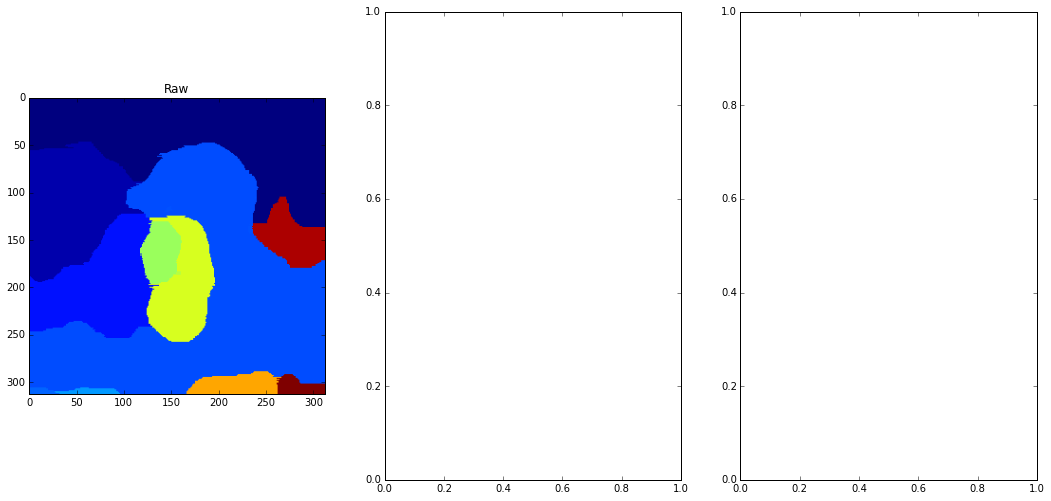

In [55]:
def display_affs(raw, label, seg):
    fig = plt.figure(figsize=(20, 10))
    fig.set_facecolor('white')
    ax1, ax2, ax3 = fig.add_subplot(1, 3, 1), fig.add_subplot(1, 3, 2), fig.add_subplot(1, 3, 3)
    fig.subplots_adjust(left=0.2, bottom=0.25)
    ax1.imshow(np.transpose(raw[:, :, :, 1],(2,1,0)))
    ax1.set_title('Raw')
    plt.show()
def display_segs(raw, label, seg):
    fig = plt.figure(figsize=(20, 10))
    fig.set_facecolor('white')
    ax1, ax2, ax3 = fig.add_subplot(1, 3, 1), fig.add_subplot(1, 3, 2), fig.add_subplot(1, 3, 3)
    fig.subplots_adjust(left=0.2, bottom=0.25)
    ax1.imshow(raw[1, :, :])
    ax1.set_title('Raw')
    plt.show()
def display_seg_z(raw):
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0.2, bottom=0.25)
    ax1.imshow(raw[1, :, :], cmap=cmap)
    plt.show()
# display_arbitrary(preds,preds,preds)
display_segs(seg,seg,seg)